In [1]:
# Install necessary packages

In [2]:
# pip install open-fdd --upgrade

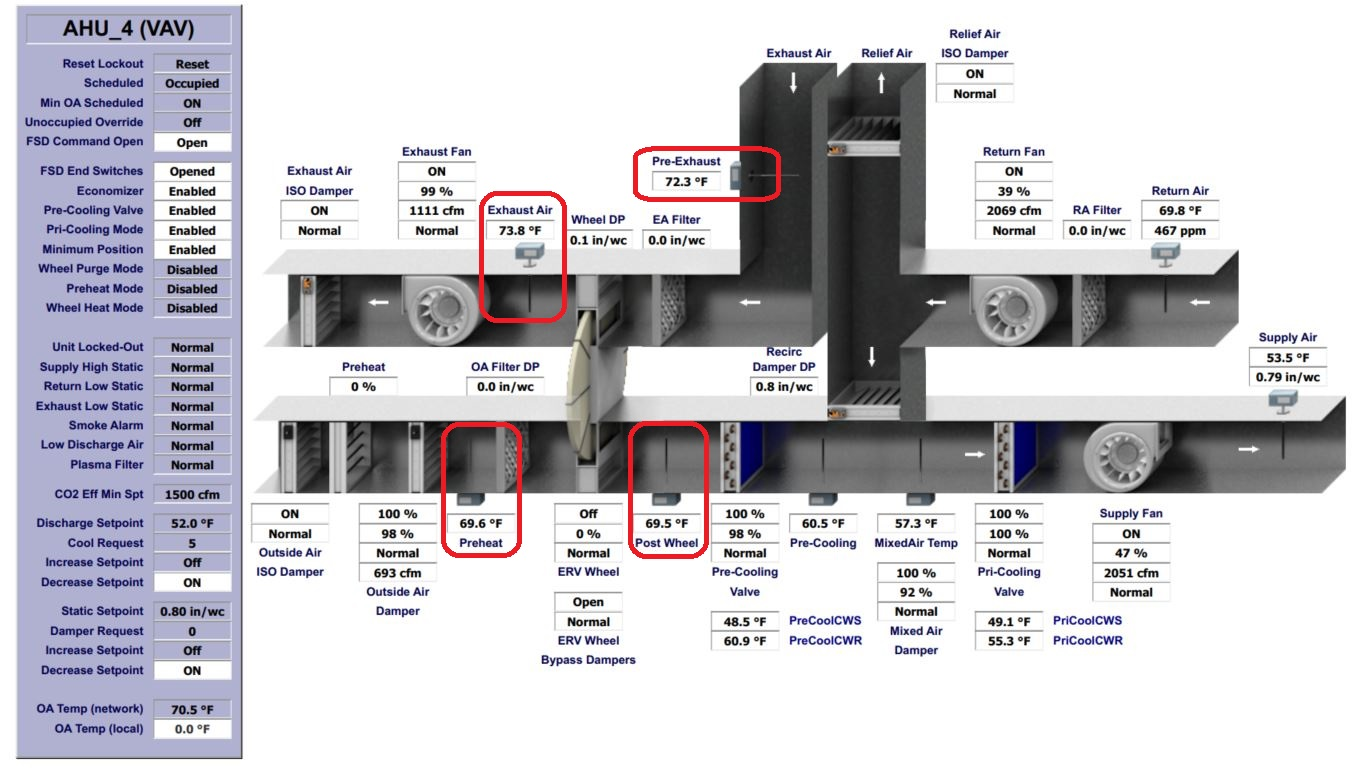

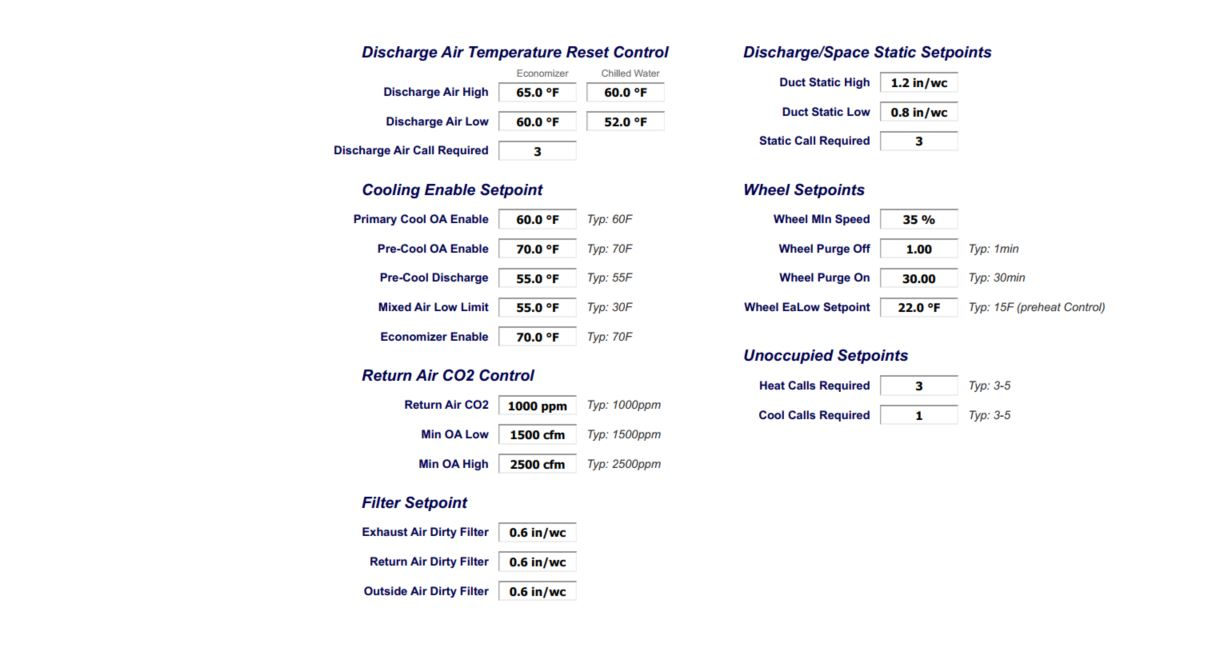

In [3]:
# display BAS screenshots

from IPython.display import Image, display

# Specify the path to your JPEG file
image_path1 = r"C:\Users\bbartling\Documents\AHU4.jpg"
image_path2 = r"C:\Users\bbartling\Documents\AHU4_points.jpg"

# Display the images
display(Image(filename=image_path1))
display(Image(filename=image_path2))

In [4]:
import pandas as pd
import numpy as np


In [5]:
# Load your data
ahu_data = r"C:\Users\bbartling\Documents\brick_data_July_2024.csv"
df = pd.read_csv(ahu_data)

df.head()

,timestamp,AHU1_PostWheelTemp (°F),AHU1_EA_Flow (cfm),AHU1_CW_ValveAO (%),AHU1_MA_RA_DamperAO (%),AHU1_EA_FanSpeed (%),AHU1_EATemp (°F),AHU1_MATemp (°F),AHU1_PreCoolValveAO (%),AHU1_PreEA_Temp (°F),...,AV2_7_SpaceTemp,AV2_15_SpaceTemp,AV1_48_Co2,AV1_48_SpaceTemp,AV3_6_SpaceTemp,AV3_28B_SpaceTemp,AV4_6_Co2,AV4_6_SpaceTemp,AV4_17_SpaceTemp,AV4_17_Co2
0,2024-07-01 00:00:00,68.8,7.0,0.0,0.0,100.0,72.8,69.5,0.0,72.4,...,74.11,75.87,381.39,75.46,75.27,76.17,388.45,77.27,76.37,380.40
1,2024-07-01 00:04:59,68.8,7.0,0.0,0.0,100.0,72.8,69.6,0.0,72.4,...,74.11,75.84,381.46,75.47,75.23,76.14,388.45,77.26,76.37,380.41
2,2024-07-01 00:05:00,68.8,7.0,0.0,0.0,100.0,72.8,69.6,0.0,72.4,...,74.11,75.84,381.46,75.47,75.23,76.14,388.45,77.26,76.37,380.41
3,2024-07-01 00:09:58,68.8,7.0,0.0,0.0,100.0,72.8,69.6,0.0,72.4,...,74.11,75.84,381.58,75.48,75.19,76.08,389.47,77.22,76.36,380.39
4,2024-07-01 00:10:00,68.8,7.0,0.0,0.0,100.0,72.8,69.6,0.0,72.4,...,74.11,75.84,381.58,75.48,75.19,76.08,389.47,77.22,76.36,380.39


In [6]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)

df.head()

,AHU1_PostWheelTemp (°F),AHU1_EA_Flow (cfm),AHU1_CW_ValveAO (%),AHU1_MA_RA_DamperAO (%),AHU1_EA_FanSpeed (%),AHU1_EATemp (°F),AHU1_MATemp (°F),AHU1_PreCoolValveAO (%),AHU1_PreEA_Temp (°F),AHU1_DAT (°F),...,AV2_7_SpaceTemp,AV2_15_SpaceTemp,AV1_48_Co2,AV1_48_SpaceTemp,AV3_6_SpaceTemp,AV3_28B_SpaceTemp,AV4_6_Co2,AV4_6_SpaceTemp,AV4_17_SpaceTemp,AV4_17_Co2
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-07-01 00:00:00,68.8,7.0,0.0,0.0,100.0,72.8,69.5,0.0,72.4,70.3,...,74.11,75.87,381.39,75.46,75.27,76.17,388.45,77.27,76.37,380.40
2024-07-01 00:04:59,68.8,7.0,0.0,0.0,100.0,72.8,69.6,0.0,72.4,70.3,...,74.11,75.84,381.46,75.47,75.23,76.14,388.45,77.26,76.37,380.41
2024-07-01 00:05:00,68.8,7.0,0.0,0.0,100.0,72.8,69.6,0.0,72.4,70.3,...,74.11,75.84,381.46,75.47,75.23,76.14,388.45,77.26,76.37,380.41
2024-07-01 00:09:58,68.8,7.0,0.0,0.0,100.0,72.8,69.6,0.0,72.4,70.3,...,74.11,75.84,381.58,75.48,75.19,76.08,389.47,77.22,76.36,380.39
2024-07-01 00:10:00,68.8,7.0,0.0,0.0,100.0,72.8,69.6,0.0,72.4,70.3,...,74.11,75.84,381.58,75.48,75.19,76.08,389.47,77.22,76.36,380.39


In [7]:
# Filter columns that start with 'AHU4_'
ahu4_columns = [col for col in df.columns if col.startswith('AHU4_')]

# Reindex the DataFrame with the filtered columns
df = df[ahu4_columns]

df.head()


,AHU4_PostWheelTemp (°F),AHU4_EA_Flow (cfm),AHU4_CW_ValveAO (%),AHU4_MA_RA_DamperAO (%),AHU4_EA_FanSpeed (%),AHU4_EATemp (°F),AHU4_MATemp (°F),AHU4_PreCoolValveAO (%),AHU4_PreEA_Temp (°F),AHU4_DAT (°F),...,AHU4_PreHeatTemp_value (°F),AHU4_OA_Flow_value (cfm),AHU4_SaFanFlow_value (cfm),AHU4_RATemp_value (°F),AHU4_SaFanSpeedAO_value (%),AHU4_WheelSpeedAO_value (%),AHU4_SaStatic_value (in/wc),AHU4_RA_Flow_value (cfm),AHU4_StaticSPt,AHU4_DischargeSPt
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-07-01 00:00:00,66.0,926.0,100.0,100.0,100.0,75.7,66.2,0.0,74.1,69.1,...,65.2,3225.0,8980.0,73.1,100.0,0.0,0.42,6406.0,0.8,52.03
2024-07-01 00:04:59,66.6,984.0,100.0,100.0,100.0,75.0,67.0,0.0,74.1,69.6,...,65.3,3255.0,8712.0,73.1,100.0,0.0,0.42,6350.0,0.8,52.09
2024-07-01 00:05:00,66.6,984.0,100.0,100.0,100.0,75.0,67.0,0.0,74.1,69.6,...,65.3,3255.0,8712.0,73.1,100.0,0.0,0.42,6350.0,0.8,52.09
2024-07-01 00:09:58,66.2,948.0,100.0,100.0,100.0,75.2,66.4,0.0,74.1,69.4,...,65.1,3081.0,8870.0,73.1,100.0,0.0,0.42,6339.0,0.8,52.28
2024-07-01 00:10:00,66.2,948.0,100.0,100.0,100.0,75.2,66.4,0.0,74.1,69.4,...,65.1,3081.0,8870.0,73.1,100.0,0.0,0.42,6339.0,0.8,52.28


In [8]:
df.columns

Index(['AHU4_PostWheelTemp (°F)', 'AHU4_EA_Flow (cfm)', 'AHU4_CW_ValveAO (%)',
       'AHU4_MA_RA_DamperAO (%)', 'AHU4_EA_FanSpeed (%)', 'AHU4_EATemp (°F)',
       'AHU4_MATemp (°F)', 'AHU4_PreCoolValveAO (%)', 'AHU4_PreEA_Temp (°F)',
       'AHU4_DAT (°F)', 'AHU4_RA_CO2', 'AHU4_PreHeatTemp_value (°F)',
       'AHU4_OA_Flow_value (cfm)', 'AHU4_SaFanFlow_value (cfm)',
       'AHU4_RATemp_value (°F)', 'AHU4_SaFanSpeedAO_value (%)',
       'AHU4_WheelSpeedAO_value (%)', 'AHU4_SaStatic_value (in/wc)',
       'AHU4_RA_Flow_value (cfm)', 'AHU4_StaticSPt', 'AHU4_DischargeSPt'],
      dtype='object')

In [9]:
# OPTIONAL is make smaller monthly datasets

'''
# Example of breaking out the DataFrame by month
dfs_by_month = {month: data for month, data in df.groupby(df.index.to_period("M"))}

# Example of accessing the DataFrame for March 2023
march_df = dfs_by_month[pd.Period("2023-03")]

print("March 2023 DataFrame:")
print(march_df)
'''

'\n# Example of breaking out the DataFrame by month\ndfs_by_month = {month: data for month, data in df.groupby(df.index.to_period("M"))}\n\n# Example of accessing the DataFrame for March 2023\nmarch_df = dfs_by_month[pd.Period("2023-03")]\n\nprint("March 2023 DataFrame:")\nprint(march_df)\n'

In [10]:
from open_fdd.air_handling_unit.faults.helper_utils import HelperUtils

utils = HelperUtils()

df = utils.apply_rolling_average_if_needed(df)

In [11]:
# Check for NaN values in each column
for col in df.columns:
    if df[col].isnull().any():
        print(f"NaN values found in column: {col}")

        # Remove rows with any NaN values, then forward and backfill
        df = df.dropna().ffill().bfill()
        print("DataFrame has been cleaned for NaNs and has also been forward and backfilled.")

In [12]:
# Checking data types of each column
print("Data Types:")
print(df.dtypes)

Data Types:
AHU4_PostWheelTemp (°F)        float64
AHU4_EA_Flow (cfm)             float64
AHU4_CW_ValveAO (%)            float64
AHU4_MA_RA_DamperAO (%)        float64
AHU4_EA_FanSpeed (%)           float64
AHU4_EATemp (°F)               float64
AHU4_MATemp (°F)               float64
AHU4_PreCoolValveAO (%)        float64
AHU4_PreEA_Temp (°F)           float64
AHU4_DAT (°F)                  float64
AHU4_RA_CO2                    float64
AHU4_PreHeatTemp_value (°F)    float64
AHU4_OA_Flow_value (cfm)       float64
AHU4_SaFanFlow_value (cfm)     float64
AHU4_RATemp_value (°F)         float64
AHU4_SaFanSpeedAO_value (%)    float64
AHU4_WheelSpeedAO_value (%)    float64
AHU4_SaStatic_value (in/wc)    float64
AHU4_RA_Flow_value (cfm)       float64
AHU4_StaticSPt                 float64
AHU4_DischargeSPt              float64
dtype: object


In [13]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("\nMax Values:")
    print(df.max(numeric_only=True))


Max Values:
AHU4_PostWheelTemp (°F)          85.60
AHU4_EA_Flow (cfm)             1899.00
AHU4_CW_ValveAO (%)             100.00
AHU4_MA_RA_DamperAO (%)         100.00
AHU4_EA_FanSpeed (%)            100.00
AHU4_EATemp (°F)                 92.90
AHU4_MATemp (°F)                 84.20
AHU4_PreCoolValveAO (%)         100.00
AHU4_PreEA_Temp (°F)             83.90
AHU4_DAT (°F)                    94.00
AHU4_RA_CO2                     553.00
AHU4_PreHeatTemp_value (°F)      92.10
AHU4_OA_Flow_value (cfm)       3716.00
AHU4_SaFanFlow_value (cfm)     9606.00
AHU4_RATemp_value (°F)           81.20
AHU4_SaFanSpeedAO_value (%)     100.00
AHU4_WheelSpeedAO_value (%)     100.00
AHU4_SaStatic_value (in/wc)       2.05
AHU4_RA_Flow_value (cfm)       6459.00
AHU4_StaticSPt                    1.20
AHU4_DischargeSPt                60.91
dtype: float64


In [14]:
# OPTIONAL CONVERT AO's based on above info if they are floats between 0.0 and 100.0

# the floats between 0.0 and 100.0 so we need to convert to 0.0 and 1.0 ranges
percentage_columns = [
    ["AHU4_MA_RA_DamperAO (%)"],
    ["AHU4_SaFanSpeedAO_value (%)"],
    ["AHU4_CW_ValveAO (%)"],
    ["AHU4_WheelSpeedAO_value (%)"],
    ["AHU4_EA_FanSpeed (%)"]
]

for col in percentage_columns:
    df[col] = df[col] / 100.0

df.head()



,AHU4_PostWheelTemp (°F),AHU4_EA_Flow (cfm),AHU4_CW_ValveAO (%),AHU4_MA_RA_DamperAO (%),AHU4_EA_FanSpeed (%),AHU4_EATemp (°F),AHU4_MATemp (°F),AHU4_PreCoolValveAO (%),AHU4_PreEA_Temp (°F),AHU4_DAT (°F),...,AHU4_PreHeatTemp_value (°F),AHU4_OA_Flow_value (cfm),AHU4_SaFanFlow_value (cfm),AHU4_RATemp_value (°F),AHU4_SaFanSpeedAO_value (%),AHU4_WheelSpeedAO_value (%),AHU4_SaStatic_value (in/wc),AHU4_RA_Flow_value (cfm),AHU4_StaticSPt,AHU4_DischargeSPt
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-07-01 00:00:00,66.0,926.0,1.0,1.0,1.0,75.7,66.2,0.0,74.1,69.1,...,65.2,3225.0,8980.0,73.1,1.0,0.0,0.42,6406.0,0.8,52.03
2024-07-01 00:04:59,66.6,984.0,1.0,1.0,1.0,75.0,67.0,0.0,74.1,69.6,...,65.3,3255.0,8712.0,73.1,1.0,0.0,0.42,6350.0,0.8,52.09
2024-07-01 00:05:00,66.6,984.0,1.0,1.0,1.0,75.0,67.0,0.0,74.1,69.6,...,65.3,3255.0,8712.0,73.1,1.0,0.0,0.42,6350.0,0.8,52.09
2024-07-01 00:09:58,66.2,948.0,1.0,1.0,1.0,75.2,66.4,0.0,74.1,69.4,...,65.1,3081.0,8870.0,73.1,1.0,0.0,0.42,6339.0,0.8,52.28
2024-07-01 00:10:00,66.2,948.0,1.0,1.0,1.0,75.2,66.4,0.0,74.1,69.4,...,65.1,3081.0,8870.0,73.1,1.0,0.0,0.42,6339.0,0.8,52.28


In [15]:


# Configuration dictionary
config_dict = {
    # used for report name
    'AHU_NAME': "MZVAV_1",

    # timestamp column name
    'INDEX_COL_NAME': "timestamp",

    'DUCT_STATIC_COL': "SaStatic",
    'DUCT_STATIC_SETPOINT_COL': "Static_SP",
    'SUPPLY_VFD_SPEED_COL': "AHU4_SaFanSpeedAO_value (%)",

    'MAT_COL': "MA_Temp",
    'OAT_COL': "OaTemp",
    'SAT_COL': "HC1_DaTemp",
    'RAT_COL': "RA_Temp",

    'HEATING_SIG_COL': None,  
    'COOLING_SIG_COL': "cooling_signal",  # calculated in pandas for this AHU
    'ECONOMIZER_SIG_COL': "OA_RA_Damper",

    # Set to None to potentially skip Fault Condition 6
    'SUPPLY_FAN_AIR_VOLUME_COL': "SA_Flow_CFM",  

    # Set to None to potentially skip Fault Condition 14
    'CLG_COIL_ENTER_TEMP_COL': None,
    'CLG_COIL_LEAVE_TEMP_COL': None,

    # Set to None to potentially skip Fault Condition 15
    'HTG_COIL_ENTER_TEMP_COL': None,
    'HTG_COIL_LEAVE_TEMP_COL': None,

    # New ERV Fault 16 params
    "ERV_EFFICIENCY_MIN_HEATING": 0.7, 
    "ERV_EFFICIENCY_MAX_HEATING": 0.8,
    "ERV_EFFICIENCY_MIN_COOLING": 0.45,
    "ERV_EFFICIENCY_MAX_COOLING": 0.6,
    "OAT_LOW_THRESHOLD": 32.0,
    "OAT_HIGH_THRESHOLD": 80.0,

    "ERV_OAT_ENTER_COL": "AHU4_PreHeatTemp_value (°F)",
    "ERV_OAT_LEAVING_COL": "AHU4_PostWheelTemp (°F)",
    "ERV_EAT_ENTER_COL": "AHU4_PreEA_Temp (°F)",
    "ERV_EAT_LEAVING_COL": "AHU4_EATemp (°F)",

    'SAT_SETPOINT_COL': "Eff_DaTempSP",
    'CONSTANT_LEAVE_TEMP_SP': False,
    'CONSTANT_LEAVE_TEMP_SP_VAL': 55.0,

    'VFD_SPEED_PERCENT_ERR_THRES': 0.05,
    'VFD_SPEED_PERCENT_MAX': 0.99,
    'DUCT_STATIC_INCHES_ERR_THRES': 0.1,
    'OUTDOOR_DEGF_ERR_THRES': 5.0,
    'MIX_DEGF_ERR_THRES': 5.0,
    'RETURN_DEGF_ERR_THRES': 2.0,
    'SUPPLY_DEGF_ERR_THRES': 2.0,
    'COIL_TEMP_ENTER_ERR_THRES': 2.0,
    'COIL_TEMP_LEAV_ERR_THRES': 2.0,
    'DELTA_T_SUPPLY_FAN': 2.0,

    'DELTA_OS_MAX': 3,
    'AHU_MIN_OA_DPR': 0.20,
    'OAT_RAT_DELTA_MIN': 10.0,
    'AIRFLOW_ERR_THRES': 0.3,
    'AHU_MIN_OA_CFM_DESIGN': 2500,
    'TROUBLESHOOT_MODE': False,
    'ROLLING_WINDOW_SIZE': 10
}

In [16]:
# create empty dict to hold fault counts which we can do something with later

fault_counts = {}

fc16_flag = 1 if temperature deltas and expected efficiency is ineffective for N consecutive values else 0 
Fault Condition 16: ERV is an ineffective heat transfer fault. This fault occurs when the ERV's efficiency is outside the acceptable range based on the delta temperature across the ERV outside air enter temperature and ERV outside air leaving temperature, indicating poor heat transfer. It considers both heating and cooling conditions where each have acceptable ranges in percentage for expected heat transfer efficiency. The percentage needs to be a float between 0.0 and 1.0.
Required inputs are the ERV outside air entering temperature, ERV outside air leaving temperature, ERV exhaust entering temperature, ERV exhaust leaving temperature, and AHU supply fan VFD speed.
Your config dictionary is mapped as: AHU4_PreHeatTemp_value (°F), AHU4_PostWheelTemp (°F), AHU4_PreEA_Temp (°F), AHU4_EATemp (°F), AHU4_SaFanSpeedAO_value (%)
FC16 Fault Sum: 3135
total_days: 31.0
total_hours: 744
hou

C:\Users\bbartling\AppData\Roaming\Python\Python312\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


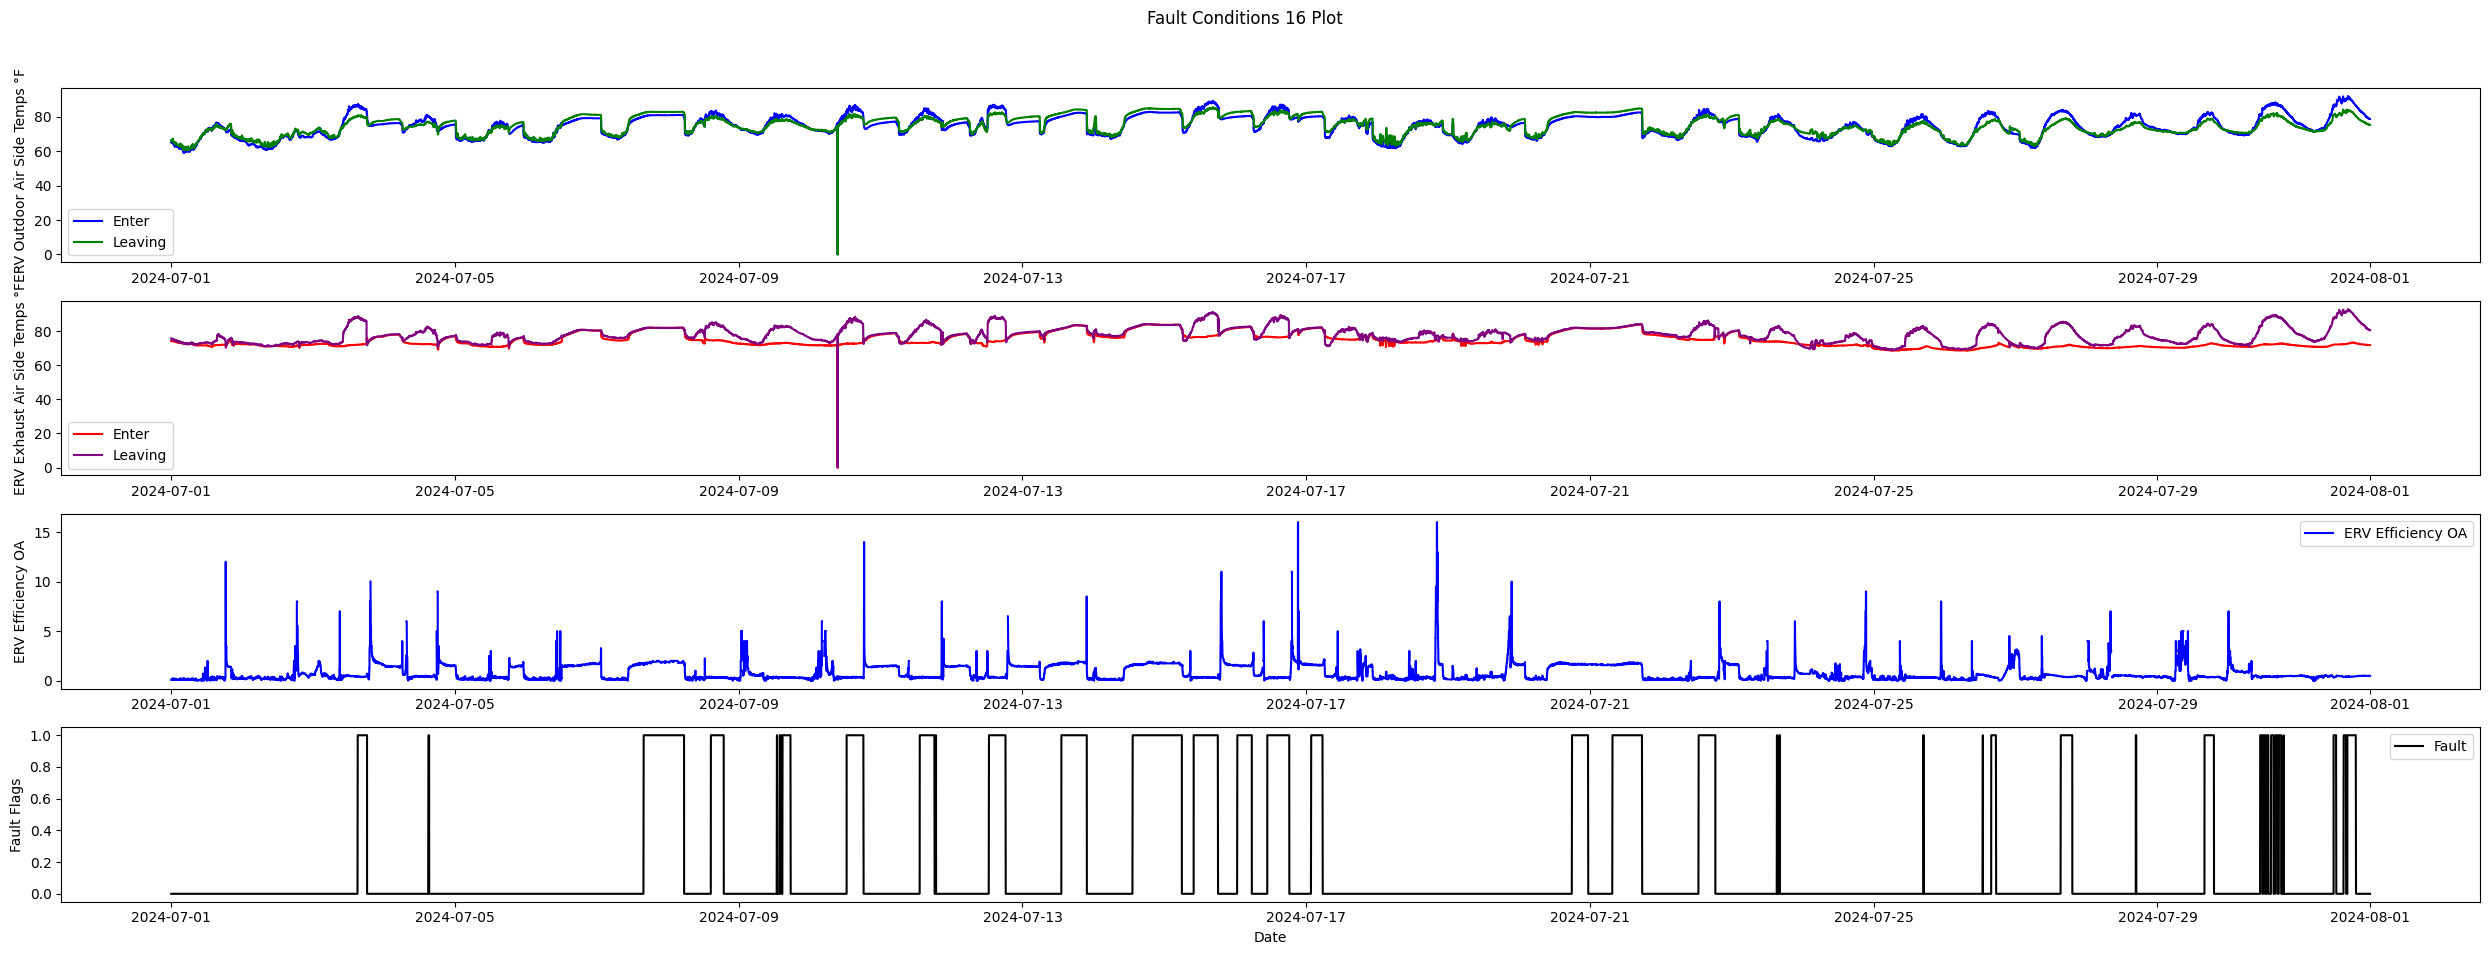

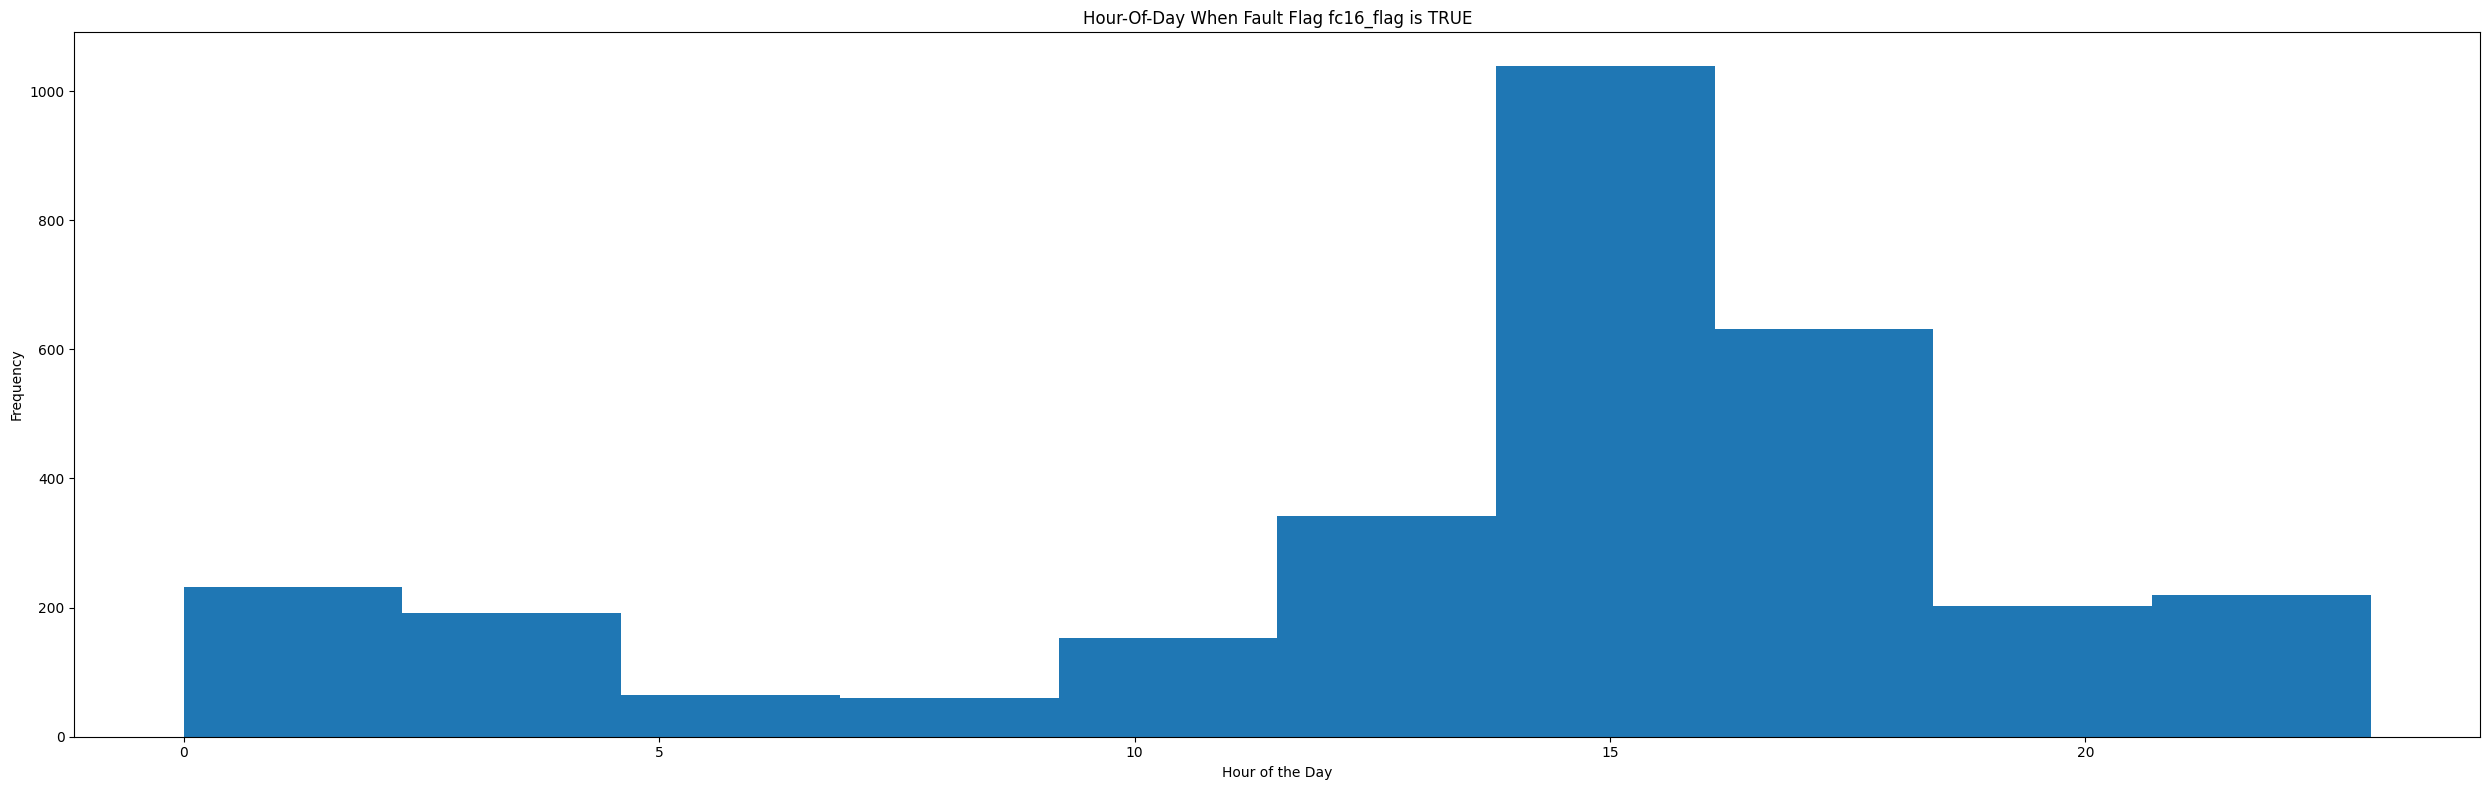

In [17]:
from open_fdd.air_handling_unit.faults import FaultConditionSixteen
from open_fdd.air_handling_unit.reports import FaultCodeSixteenReport

# Create an instance of FaultConditionOne
fc16 = FaultConditionSixteen(config_dict)
fc16_required_columns = fc16.get_required_columns()
print(fc16_required_columns)

# Apply the fault condition to the DataFrame
df_fc16 = fc16.apply(df)

fault_counts["fc16_fault_sum"] = df_fc16["fc16_flag"].sum()
print(f"FC16 Fault Sum: {fault_counts['fc16_fault_sum']}")


# Retrieve and print all the metrics (keys and values) from summarize_fault_times
fc16_report = FaultCodeSixteenReport(config_dict)
summary_metrics = fc16_report.summarize_fault_times(df_fc16)

# Print each key and value
for key, value in summary_metrics.items():
    print(f"{key}: {value}")

# Generate and display the report if there is a fault
if fault_counts['fc16_fault_sum'] != 0:
    fc16_report.display_report_in_ipython(df_fc16)
else:
    print("No faults found.")
